In [24]:
# importing necessary libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit, execute, Aer
from qiskit.circuit import ParameterVector
import random

In [25]:
# reading the data
data = pd.read_csv('iris.csv')
data.columns = ['sl','sw','pl','pw','species']
data.head()

,sl,sw,pl,pw,species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [26]:
# types of flowers
types = data['species'].unique()
types

array(['Setosa', 'Versicolor', 'Virginica'], dtype=object)

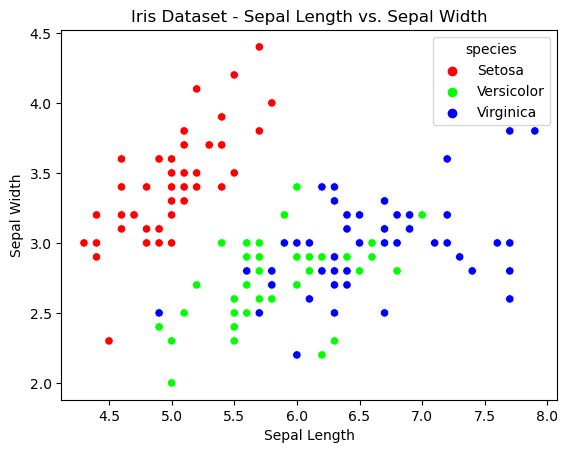

In [27]:
custom = ['#FF0000', '#00FF00', '#0000FF']
sns.scatterplot(data=data, x='sl', y='sw', hue='species', palette=custom)
# Add labels and title
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Iris Dataset - Sepal Length vs. Sepal Width')

# Display the plot
plt.show()

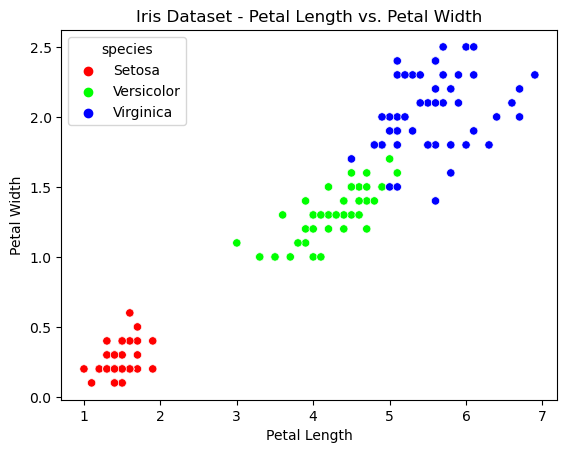

In [28]:
custom = ['#FF0000', '#00FF00', '#0000FF']
sns.scatterplot(data=data, x='pl', y='pw', hue='species', palette=custom)
# Add labels and title
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.title('Iris Dataset - Petal Length vs. Petal Width')

# Display the plot
plt.show()

In [29]:
# replacing the types with numerical data
data.replace(types[0],+1,inplace=True)
data.replace(types[1],0,inplace=True)
data.replace(types[2],-1,inplace=True)
data.sample(5)

,sl,sw,pl,pw,species
6,4.6,3.4,1.4,0.3,1
62,6.0,2.2,4.0,1.0,0
98,5.1,2.5,3.0,1.1,0
66,5.6,3.0,4.5,1.5,0
29,4.7,3.2,1.6,0.2,1


<Axes: >

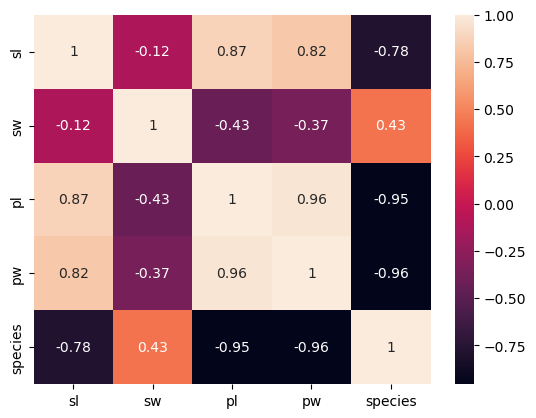

In [30]:
# correlation matrix
sns.heatmap(data.corr(), annot=True)

In [31]:
# Splitting the data
from sklearn.model_selection import train_test_split
x = data.iloc[:,:4].to_numpy()
y = data.iloc[:,4].to_numpy()
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.3, random_state=25)

In [32]:
# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(xtrain)
xtrain = pca.transform(xtrain)
xtest = pca.transform(xtest)
qubits = len(xtrain[0])

In [33]:
# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [11]:
# QKSVM

In [12]:
# FeatureMap Circuit
def FeatureMap(n,reps):
    qc = QuantumCircuit(n)
    params = ParameterVector('x',n)
    for i in range(reps):
        for j in range(n):
            qc.h(j)
            qc.rz(params[j],j)
            qc.ry(params[j],j)
            if j!=0:
                qc.rzz(params[j],0,j)
    return qc

In [13]:
# get the kernel matrix
def kernel(x,y,Fmap):
    
    def state(qc):
        backend = Aer.get_backend('statevector_simulator')
        result = execute(qc, backend).result()
        return np.array(result.get_statevector())

    def element(i,j):
        qc1 = Fmap.copy()
        qc1 = qc1.bind_parameters(i)
        qc2 = Fmap.copy()
        qc2 = qc2.bind_parameters(j)
        sv1 = np.matrix(state(qc1))
        sv2 = np.matrix(state(qc2))
        return abs(np.matmul(sv1,sv2.T.conj()))**2
    
    nx = len(x)
    ny = len(y)
    matrix = np.zeros((nx,ny))
    for i in tqdm(range(nx)):
        for j in range(ny):
            ele = element(x[i],y[j])
            matrix[i][j] = ele
    return matrix

In [14]:
# inputing the data
Fmap = FeatureMap(qubits,1)
trainmat = kernel(xtrain,xtrain,Fmap)
testmat = kernel(xtest,xtrain,Fmap)

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:05<00:00,  1.46s/it]


In [15]:
# implementing a classifier using the computed kernel
from sklearn.svm import SVC
svc = SVC(kernel='precomputed')
svc.fit(trainmat, ytrain)
score = svc.score(testmat, ytest)
ypred = svc.predict(testmat)
print(f'Precomputed kernel classification test score: {score}')

Precomputed kernel classification test score: 0.9555555555555556


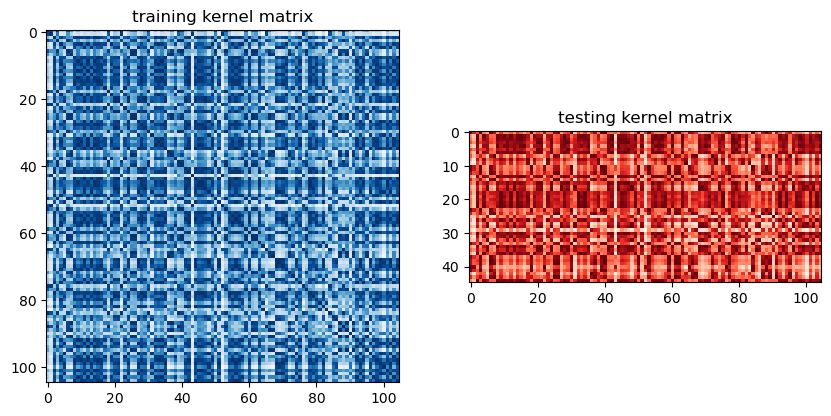

In [16]:
# plotting the kernel matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(trainmat),interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(testmat), interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

In [23]:
data.head()

,sl,sw,pl,pw
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [37]:
import numpy as np
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit.library import TwoLocal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load the Iris dataset and split it into features and labels
feature_dim = 2
data = pd.read_csv('iris.csv')
data.columns = ['sl','sw','pl','pw','species']

# Splitting the data
from sklearn.model_selection import train_test_split
x = data.iloc[:,:4].to_numpy()
y = data.iloc[:,4].to_numpy()
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = 0.3, random_state=25)

# Dimensionality Reduction using PCA
from sklearn.decomposition import PCA
pca = PCA(.95)
pca.fit(xtrain)
xtrain = pca.transform(xtrain)
xtest = pca.transform(xtest)
qubits = len(xtrain[0])

# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xtest = scaler.transform(xtest)

In [39]:
# Define the quantum circuit for the variational form
num_qubits = 2 * feature_dim
depth = 2
entanglement = 'full'
entangler_map = [[i, j] for i in range(feature_dim) for j in range(feature_dim, num_qubits)]
var_form = TwoLocal(num_qubits, 'ry', 'cz', reps=depth, entanglement=entanglement)

# Define the classical SVM classifier
svm = SVC(kernel='linear')

# Train the quantum variational SVM
quantum_instance = Aer.get_backend('statevector_simulator')
optimal_params = None
optimal_score = 0

In [43]:
for _ in tqdm(range(10)):
    # Generate random initial parameters
    initial_params = np.random.uniform(0, 2 * np.pi, var_form.num_parameters)

    # Construct the quantum circuit
    qc = QuantumCircuit(num_qubits)
    qc.append(var_form.assign_parameters(initial_params), qc.qubits)

    # Generate the feature map by applying the variational form to the training data
    feature_map_train = np.real(np.asarray([execute(qc, backend=quantum_instance, parameter_binds={}).result().get_statevector() for _ in xtrain]))

    # Train the classical SVM classifier
    svm.fit(feature_map_train, ytrain)

    # Generate the feature map for the testing data
    feature_map_test = np.real(np.asarray([execute(qc, backend=quantum_instance, parameter_binds={}).result().get_statevector() for _ in xtest]))

    # Evaluate the accuracy score
    score = svm.score(feature_map_test, ytest)

    # Update the optimal parameters if the score is higher
    if score > optimal_score:
        optimal_score = score
        optimal_params = initial_params

# Print the optimal score and parameters
print("Optimal Score:", optimal_score)
print("Optimal Parameters:", optimal_params)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.16s/it]

Optimal Score: 0.26666666666666666
Optimal Parameters: [4.9385533  3.41280934 2.59063074 1.68901963 4.05411079 3.63775895
 2.39868375 3.9207448  4.60424791 0.0719529  5.00255446 4.44820705]
